In [30]:
import seaborn as sns
import pandas as pd
import numpy as np
import json
import glob
import re
import matplotlib.pyplot as plt

In [25]:
folder = "logs/02_satEveningWithStress"

lines = []
for file_name in glob.glob("*.log", root_dir=folder):
    with open(folder + "/" + file_name) as f:
        while line := f.readline():
            if "PFSTT" in line and "dashboard is deleting returned header" not in line:
                json_string = re.search(r'PFSTT(.*?)TTSFP', line).group(1)
                try:
                    lines.append(json.loads(json_string))
                except:
                    print("Error in file: " + file_name)
                    print("Line: " + line)
                    print("JSON: " + json_string)
                    print("-----")
                    continue

df = pd.DataFrame(lines)
# Set Data Types
df["start"] = df["start"].astype(float)
df["end"] = df["end"].astype(float)
df["request_timestamp"] = df["request_timestamp"].astype(float)
df["request_deadline"] = df["request_deadline"].astype(float)

# Calculate Durations
min_timestamp = df["request_timestamp"].min()
last_experiment_timestamp = df["end"].max()
df["request_timestamp"] = df["request_timestamp"] - min_timestamp
df["request_deadline"] = df["request_deadline"] - min_timestamp
df["start"] = df["start"] - min_timestamp
df["end"] = df["end"] - min_timestamp

# Add new columns
df["run_duration"] = df["end"] - df["start"]
df["time_to_deadline"] = df["request_deadline"] - df["start"]
df["init_duration"] = df["start"] - df["request_timestamp"]
df

,function,start,end,request_timestamp,request_deadline,mode,callid,id,run_duration,time_to_deadline,init_duration
0,check,152.323730,416.278076,0.0,30000.0,bored,d6c0a0b3b99740fbb8772f179f4e8a3c,NaN,263.954346,29847.676270,152.323730
1,check,75930.406982,76315.238281,75651.0,105651.0,bored,9b191281e7a1431eb95636e57482b448,NaN,384.831299,29720.593018,279.406982
2,check,76535.569824,76929.368652,76248.0,106248.0,bored,28574fb6c5e14424969d391f152d0005,NaN,393.798828,29712.430176,287.569824
3,check,77045.064697,77511.818115,76791.0,106791.0,bored,3f084726e0b04c35af727aac19e3e896,NaN,466.753418,29745.935303,254.064697
4,check,77657.860352,78165.159180,77359.0,107359.0,bored,c2a972e8e82c4b0dbed695f8b0679de8,NaN,507.298828,29701.139648,298.860352
...,...,...,...,...,...,...,...,...,...,...,...
627,email,439138.201416,440392.019775,427524.0,607524.0,bored,NaN,f5a9f4331d454affb2ac5a42533cb6a7,1253.818359,168385.798584,11614.201416
628,email,440395.295410,441659.193848,427704.0,607704.0,bored,NaN,26e215ab6235488b8b31000f844d5dd6,1263.898438,167308.704590,12691.295410
629,email,440543.395264,441794.558350,427800.0,607800.0,bored,NaN,c9cd2445653a4538a67f0a13c8ae2f54,1251.163086,167256.604736,12743.395264
630,email,441830.510254,443316.755127,427901.0,607901.0,bored,NaN,bd057bb771b44b0d8edb592644929b4f,1486.244873,166070.489746,13929.510254


In [26]:
# If you want all CPU usage values in the df set this to False
ONLY_RELEVANT_CPU = True

smaller_dfs = []
for file_name in glob.glob("*.csv", root_dir="usage/"):
    # if ONLY_RELEVANT_CPU:
    #     start_ts = int(file_name.split("_")[3].split(".")[0])
    #     if start_ts > last_experiment_timestamp or start_ts < min_timestamp - 1000*60*60*24:
    #         continue
    with open("usage/" + file_name) as f:
        smaller_dfs.append(pd.read_csv(f))
usage_df = pd.concat(smaller_dfs)
usage_df["experiment_time"] = usage_df["unix_time"] - min_timestamp

if ONLY_RELEVANT_CPU:
    # Delete all values 10 seconds after the last call ended and 10 seconds before the first call started
    print("removed before:" + str(len(usage_df[usage_df["unix_time"] <= (last_experiment_timestamp + 10000)])))
    usage_df = usage_df[usage_df["unix_time"] <= (last_experiment_timestamp + 10000)]
    print("removed after:" + str(len(usage_df[usage_df["unix_time"] >= (min_timestamp - 10000)])))
    usage_df = usage_df[usage_df["unix_time"] >= (min_timestamp - 10000)]

usage_df

removed before:454
removed after:201


,unix_time,cpu_percent,ram_percent,experiment_time
0,1694893184912,22.62,22.86,48179.0
1,1694893186924,23.68,22.89,50191.0
2,1694893188937,24.40,22.84,52204.0
3,1694893190949,26.81,22.97,54216.0
4,1694893192961,26.73,22.95,56228.0
...,...,...,...,...
196,1694893581622,20.34,28.05,444889.0
197,1694893583634,23.41,28.04,446901.0
198,1694893585646,23.35,28.03,448913.0
199,1694893587662,27.18,28.03,450929.0


In [12]:
min_timestamp

1694890883677.0

/home/trever/.local/share/virtualenvs/stats-94myh5A0/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/trever/.local/share/virtualenvs/stats-94myh5A0/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/trever/.local/share/virtualenvs/stats-94myh5A0/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/trever/.local/share/virtualenvs/stats-94myh5A0/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureW

<Axes: xlabel='request_timestamp', ylabel='run_duration'>

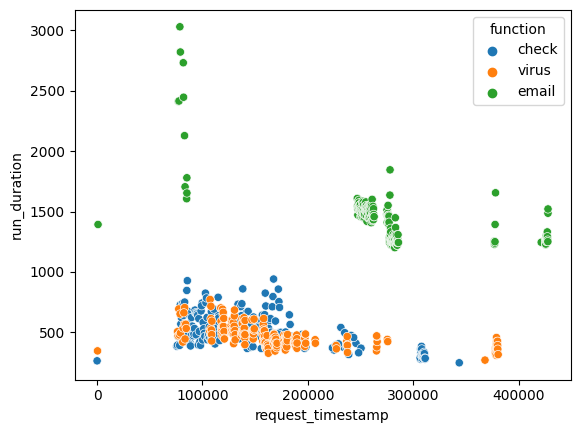

In [31]:
sns.scatterplot(data=df, x="request_timestamp", y="run_duration", hue="function")

/home/trever/.local/share/virtualenvs/stats-94myh5A0/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/trever/.local/share/virtualenvs/stats-94myh5A0/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/trever/.local/share/virtualenvs/stats-94myh5A0/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/trever/.local/share/virtualenvs/stats-94myh5A0/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureW

<Axes: xlabel='experiment_time', ylabel='cpu_percent'>

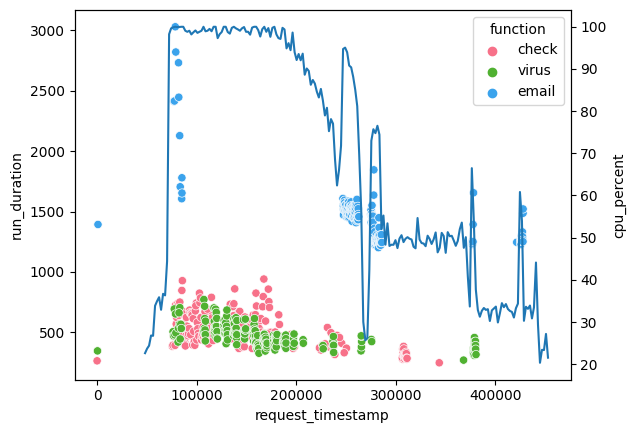

In [34]:

sns.scatterplot(data=df[df["function"] == "check"], x="request_timestamp", y="run_duration", hue="mode")
sns.scatterplot(data=df[df["function"] != "check"], x="request_timestamp", y="run_duration", hue="function", palette="husl")
#sns.scatterplot(data=df, x="request_timestamp", y="run_duration", hue="function", palette="husl")
ax2 = plt.twinx()
sns.lineplot(ax=ax2, data=usage_df, x="experiment_time", y="cpu_percent")

In [35]:
df.groupby("callid")